In [192]:
import pandas as pd
import pandas_profiling
from pandas import Series
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import optuna
from collections import Counter
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import re
import math
import copy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, cohen_kappa_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, plot_precision_recall_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from importlib import reload
np.warnings.filterwarnings('ignore')

print(os.listdir('./data'))
PATH_to_file = './data/'

['.ipynb_checkpoints', 'sample_submission.csv', 'test.csv', 'testм.csv', 'train.csv', 'train2.csv', 'trainм.csv']


In [193]:
RANDOM_SEED = 42
!pip freeze > requirements.txt
CURRENT_DATE = pd.to_datetime('09/11/2020')

In [194]:
def result_EDA_feature(d_feature, d_train, d_test, d_n_cols, d_EDA_done_cols, d_old_len_train):
    # записываем признак в список проанализированных признаков
    d_EDA_done_cols.append(d_feature)
    d_len_ = len(d_EDA_done_cols)
    print(f'В результате после EDA признака:= {d_feature}, обработано признаков:= {d_len_}, осталось:= {d_n_cols-d_len_}')
    # смотрим как ведет себя трейн
    temp = len(d_train)
    print('Кол-во строк в трейне:= ', temp, '. Убрали на данном шаге:= ', d_old_len_train-temp)
    d_old_len_train = temp
    # проверяем что мы случайно не испортили тест
    print('Кол-во строк в тесте:= ', len(d_test))
    return d_old_len_train, d_EDA_done_cols

In [195]:
def nunique_not_found(d_df1, d_df2, d_col):

    temp_set = set()
    temp_set2 = set()
    temp_set = set(d_df1[d_col].unique())
    temp_set2 = set(d_df2[d_col].unique())

    print(f'в столбце:= {d_col} в трейне НЕ НАЙДЕНО:= {len(temp_set2-temp_set)} уникальных значений из теста')

    return list(temp_set2-temp_set)

In [196]:
def check_df_before_merg(d_df1,d_df2):
    
    list_of_names1 = list(d_df1.columns)
    temp_dict = {}
    temp_dict['# уник_1'] = d_df1.nunique().values
    temp_dict['в первой строке_1'] =d_df1.loc[0].values
    temp_dict['тип_1'] = d_df1.dtypes
    temp_dict['имя признака_1'] = list_of_names1
    temp_df1 = pd.DataFrame.from_dict(temp_dict)
    
    
    list_of_names2 = list(d_df2.columns)
    temp_dict2 = {}
    temp_dict2['имя признака_2'] = list_of_names2
    temp_dict2['тип_2'] = d_df2.dtypes
    temp_dict2['в первой строке_2'] =d_df2.loc[0].values
    temp_dict2['# уник_2'] = d_df2.nunique().values
    temp_df2 = pd.DataFrame.from_dict(temp_dict2)
    
    temp_df = pd.concat([temp_df1,temp_df2], axis=1, sort=False)
    temp_df.reset_index(inplace = True)
    del temp_df['index']
    display(temp_df)

    temp_dict3 = {}
    temp_df3= pd.DataFrame(temp_df)
    temp_list  = []
    temp_list2  = []
    temp_list3  = []
    temp_list4  = []
    temp_list5  = []

    for i in range(len(temp_df)):
        if str(temp_df3['тип_2'][i]) != str(temp_df3['тип_1'][i]):
            temp_list.append(temp_df3['имя признака_1'][i])
            temp_list2.append(temp_df3['имя признака_2'][i])
            temp_list3.append(str(temp_df3['тип_1'][i]) + '!=' + str(temp_df3['тип_2'][i]))
            temp_list4.append(i)
        if temp_df3['# уник_2'][i]>0 and temp_df3['# уник_1'][i]/temp_df3['# уник_2'][i] > 2:
            temp_list5.append(i)
            
    temp_dict3['index']= temp_list4
    temp_dict3['имя признака_1']= temp_list
    temp_dict3['не совпадают типы'] = temp_list3
    temp_dict3['имя признака_2']= temp_list2

    temp_df4 = pd.DataFrame.from_dict(temp_dict3)
    temp_df4.set_index('index',inplace=True)

    print(f'Резюме:\n 1. Не совпали типы в:= {len(temp_df4)} столбцах\n')
    print(f'2. Уникальные значения заоблачно различаются в:= {len(temp_list5)} столбцах {temp_list5}')
    display(temp_df4)



    return

In [197]:
def hbar_group_pivot_table(d_bodyType, 
                        d_group_col, 
                        d_df, 
                        d_year_start, 
                        d_year_end,
                        d_my_font_scale):
    temp_df = d_df.copy()
    temp_df2 = temp_df[(temp_df['bodyType']==d_bodyType) & (temp_df['modelDate']>=d_year_start) & (temp_df['modelDate']<=d_year_end)]
    

    temp_pt_mean = pd.pivot_table(temp_df2, values =d_group_col, index =['bodyType','brand'], columns =['modelDate'],aggfunc = np.mean, margins=True)
    temp_list = list(temp_pt_mean['All'][d_bodyType].index)

    temp_pt_std = pd.pivot_table(temp_df2, values =d_group_col, index =['bodyType','brand'], columns =['modelDate'],aggfunc = np.std, margins=True)
    temp_std = temp_pt_std['All'][d_bodyType]['BMW']
    temp_mean = temp_pt_mean['All'][d_bodyType]['BMW']
    a = temp_pt_mean['All'][d_bodyType]['BMW']-temp_std/2
    b = temp_pt_mean['All'][d_bodyType]['BMW']+temp_std/2

    temp_list2 = list(temp_pt_std['All'][d_bodyType].index)

    temp_list_std =[]
    list_overlapp_brands =[]
    for brand in temp_list:
        if brand in temp_list2:
            std_ = temp_pt_std['All'][d_bodyType][brand]/2
        else:
            std_ = 0
        temp_list_std.append(std_)
        c = temp_pt_mean['All'][d_bodyType][brand] - std_
        d = temp_pt_mean['All'][d_bodyType][brand] + std_
        if brand != 'BMW' and ((b>=c and d>=a) or (a<=c and d<=b)):
            list_overlapp_brands.append(brand)
    
    temp_std = temp_pt_std['All'][d_bodyType]['BMW']
    temp_mean = temp_pt_mean['All'][d_bodyType]['BMW']

    plt.style.use('seaborn-paper')
    sns.set(font_scale=d_my_font_scale)
    color_text = plt.get_cmap('PuBu')(0.85)
    color_bar = plt.get_cmap('PuBu')(0.8)

    plt.figure(figsize=(12, 6))
    
    plt.barh(temp_list, width=temp_pt_mean['All'][d_bodyType].values+temp_list_std, color =color_bar)
    plt.barh(temp_list, width=temp_pt_mean['All'][d_bodyType].values, color ='red')
    plt.barh(temp_list, width=temp_pt_mean['All'][d_bodyType].values-temp_list_std, color =color_bar)


    plt.plot([temp_mean,temp_mean], [-1, len(temp_list)+1], color= 'red', label='среднее значение BMW', marker='.', lw=2, ls = '--')
    plt.plot([temp_mean-temp_std/2,temp_mean-temp_std/2], [-1, len(temp_list)+1], color='grey', label='отклонение вниз на std/2', marker='.', lw=3)
    plt.plot([temp_mean+temp_std/2,temp_mean+temp_std/2], [-1, len(temp_list)+1], color='blue', label='отклонение вверх на std/2', marker='.', lw=3)

    plt.xlabel(d_group_col, fontsize=15, color = color_text)
    plt.ylabel('brand', fontsize=15, color = color_text)
    plt.title(f'Среднее и отклонение {d_group_col} сводной таблицы сгруппированной по {d_bodyType}. modelDate с {d_year_start} по {d_year_end}', color = color_text, fontsize=15)
    plt.legend(loc="lower right", fontsize=11)
    # y_min_text = y_min +0.5*max(std_metric_train,std_metric_test)
    plt.text(100, len(temp_list)-0.5, f'кол-во брендов авто попавших в сводную таблицу = {len(temp_list)} из 36 \nкол-во брендов авто попадающих в область значений BMW = {len(list_overlapp_brands)} из 36', fontsize = 14)
    plt.show()
    print('Список релевантных брендов: ',*list_overlapp_brands)
    return list_overlapp_brands

In [198]:
def vis_cross_val_score(d_name_metric, d_vec, d_value_metric, d_my_font_scale):
    num_folds = len(d_vec['train_score'])
    avg_metric_train, std_metric_train = d_vec['train_score'].mean(), d_vec['train_score'].std()
    avg_metric_test, std_metric_test = d_vec['test_score'].mean(), d_vec['test_score'].std()

    plt.style.use('seaborn-paper')
    sns.set(font_scale=d_my_font_scale)
    color_text = plt.get_cmap('PuBu')(0.85)

    plt.figure(figsize=(12, 6))
    plt.plot(d_vec['train_score'], label='тренировочные значения', marker='.', color= 'darkblue')
    plt.plot([0,num_folds-1], [avg_metric_train, avg_metric_train], color='blue', label='среднее трен. значений ', marker='.', lw=2, ls = '--')

    plt.plot(d_vec['test_score'], label='тестовые значения', marker='.', color= 'red')
    plt.plot([0,num_folds-1], [avg_metric_test, avg_metric_test], color='lightcoral', label='среднее тест. значений ', marker='.', lw=2, ls = '--')

    plt.plot([0,num_folds-1], [d_value_metric, d_value_metric], color='grey', label='значение метрики до CV', marker='.', lw=3)

    # plt.xlim([1, num_folds])
    y_max = max(avg_metric_train,avg_metric_test) + 1.5*max(std_metric_train,std_metric_test)
    y_min = min(avg_metric_train,avg_metric_test) - 3*max(std_metric_train,std_metric_test)
    plt.ylim([y_min, y_max])
    plt.xlabel('номер фолда', fontsize=15, color = color_text)
    plt.ylabel(d_name_metric, fontsize=15, color = color_text)
    plt.title(f'Кросс-валидация по метрике {d_name_metric} на {num_folds} фолдах', color = color_text, fontsize=17)
    plt.legend(loc="lower right", fontsize=11)
    y_min_text = y_min +0.5*max(std_metric_train,std_metric_test)
    plt.text(0, y_min_text, f'{d_name_metric} на трейне = {round(avg_metric_train,3)} +/- {round(std_metric_train,3)} \n{d_name_metric} на тесте    = {round(avg_metric_test,3)} +/- {round(std_metric_test,3)} \n{d_name_metric} до CV        = {round(d_value_metric,3)}', fontsize = 15)
    plt.show()
    return

In [199]:
def model_coef(d_columns, d_model_coef_0):

    temp_dict = {}
    temp_dict['имя признака'] = d_columns
    temp_dict['коэффициент модели'] = d_model_coef_0
    temp_dict['модуль коэф'] = abs(temp_dict['коэффициент модели'])
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='columns')
    temp_df = temp_df.sort_values(by='модуль коэф', ascending=False)
    temp_df.reset_index(drop=True,inplace=True)
    
    return temp_df.loc[:,['имя признака','коэффициент модели']]

In [200]:
def GridSearchCV_for_LogReg(d_X_train, d_y_train, d_values_for_C):
    # Добавим типы регуляризации
    penalty = ['l1', 'l2']

    # Зададим ограничения для параметра регуляризации
    C = np.array(d_values_for_C)

    # Создадим гиперпараметры
    hyperparameters = dict(C=C, penalty=penalty)

    model = LogisticRegression(multi_class = 'ovr', class_weight='balanced')
    model.fit(d_X_train, d_y_train)

    # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
    clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0, scoring='f1')

    best_model = clf.fit(d_X_train, d_y_train)

    # View best hyperparameters
    temp_dict = {}
    temp_dict['Penalty'] = [best_model.best_estimator_.get_params()['penalty']]
    temp_dict['C'] = [best_model.best_estimator_.get_params()['C']]

    # temp_dict['Признак'] = [best_model.best_index_]
    # temp_list = sorted(clf.cv_results_.keys())
    # temp_dict['Кол-во'] = [len(temp_list)]
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index', columns=['Лучшие'])
    display(temp_df)

    temp_dict = {}
    # temp_dict['Лучшие признаки'] = temp_list
    # temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
    # display(temp_df.T)


    return

In [201]:
def where_1_in_corr(d_df, d_y):

    result = []
    drop_list_columns = []
    all_cols = list(d_df.columns)
    for col in all_cols:
        temp_list = d_df.index[d_df[col] == 1].tolist()
        list1 = [x for x in temp_list if x not in [col]]
        if list1 != []:
            list1.append(col)
            drop_list_columns.append(list1)
    for i in range(len(drop_list_columns)//2):
        result.append(drop_list_columns[i][0])
    result= [x for x in result if x not in [d_y]]
    return result

In [202]:
def PR_curve_with_area(d_y_true, d_y_pred_prob, d_my_font_scale):
    

    plt.style.use('seaborn-paper')
    sns.set(font_scale=d_my_font_scale)
    # sns.set_color_codes("muted")

    plt.figure(figsize=(8, 6))
    precision, recall, thresholds = precision_recall_curve(d_y_true, d_y_pred_prob, pos_label=1)
    prc_auc_score_f = auc(recall, precision)
    plt.plot(precision, recall, lw=3, label='площадь под PR кривой = %0.3f)' % prc_auc_score_f)
    
    plt.xlim([-.05, 1.0])
    plt.ylim([-.05, 1.05])
    plt.xlabel('Точность \n Precision = TP/(TP+FP)')
    plt.ylabel('Полнота \n Recall = TP/P')
    plt.title('Precision-Recall кривая')
    plt.legend(loc="upper right")
    plt.show()
    return

In [203]:
def ROC_curve_with_area(d_y_true, d_y_pred_prob, d_my_font_scale):
    roc_auc_score_f = roc_auc_score(d_y_true, d_y_pred_prob)

    plt.style.use('seaborn-paper')
    sns.set(font_scale=d_my_font_scale)
    # sns.set_color_codes("muted")

    plt.figure(figsize=(8, 6))
    fpr, tpr, thresholds = roc_curve(d_y_true, d_y_pred_prob, pos_label=1)

    plt.plot(fpr, tpr, lw=3, label='площадь под ROC кривой = %0.3f)' % roc_auc_score_f)
    plt.plot([0, 1], [0, 1], color='grey')
    plt.xlim([-.05, 1.0])
    plt.ylim([-.05, 1.05])
    plt.xlabel('Ложно классифицированные \n False Positive Rate (FPR)')
    plt.ylabel('Верно классифицированные \n True Positive Rate (TPR)')
    plt.title('ROC кривая')
    plt.legend(loc="lower right")
    plt.show()
    return

In [204]:
def test_last_pred(d_y_true, d_y_pred, d_y_pred_prob):
    last_pred[0], last_pred[1], last_pred[2] = d_y_true, d_y_pred, d_y_pred_prob
    return

In [205]:
def all_metrics(d_y_true, d_y_pred, d_y_pred_prob):
        
    d_y_true_last, d_y_pred_last, d_y_pred_prob_last =  last_pred[0], last_pred[1], last_pred[2]
    temp_dict = {}
    temp1 = accuracy_score(d_y_true, d_y_pred)
    temp2 = accuracy_score(d_y_true_last, d_y_pred_last)
    temp_dict['accuracy'] = [temp1, temp2-temp1,'(TP+TN)/(P+N)']

    temp1 = balanced_accuracy_score(d_y_true, d_y_pred)
    temp2 = balanced_accuracy_score(d_y_true_last, d_y_pred_last)
    temp_dict['balanced accuracy'] = [temp1, temp2-temp1,'сбалансированная accuracy']
    
    temp1 = precision_score(d_y_true, d_y_pred)
    temp2 = precision_score(d_y_true_last, d_y_pred_last)
    temp_dict['precision'] = [temp1, temp2-temp1,'точность = TP/(TP+FP)']
    
    temp1 = recall_score(d_y_true, d_y_pred)
    temp2 = recall_score(d_y_true_last, d_y_pred_last)
    temp_dict['recall'] = [temp1, temp2-temp1,'полнота = TP/P']
    
    temp1 = f1_score(d_y_true, d_y_pred)
    temp2 = f1_score(d_y_true_last, d_y_pred_last)
    temp_dict['f1_score'] = [temp1, temp2-temp1,'среднее гармоническое точности и полноты']
    
    temp1 = roc_auc_score(d_y_true, d_y_pred_prob)
    temp2 = roc_auc_score(d_y_true_last, d_y_pred_prob_last)
    temp_dict['roc_auc'] = [temp1, temp2-temp1,'Area Under Curve - Receiver Operating Characteristic']    
    
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index', columns=['Значение','Дельта с предыдущим','Описание'])
    display(temp_df)

    last_pred[0], last_pred[1], last_pred[2] = d_y_true, d_y_pred, d_y_pred_prob

    return

In [206]:
def plot_confusion_matrix(y_true, y_pred, d_my_font_scale, classes,
                          normalize=False,
                          title=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    list_of_labels = [['TP','FP'],['FN','TN']]
    
    if not title:
        if normalize:
            title = 'Нормализованная матрица ошибок'
        else:
            title = 'Матрица ошибок без нормализации'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    cm[0,0], cm[1,1] = cm[1,1], cm[0,0]

    # # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
   

    plt.style.use('seaborn-paper')
    cmap=plt.cm.Blues
    color_text = plt.get_cmap('PuBu')(0.85)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           
           title=title)
    ax.title.set_fontsize(15)
    ax.set_ylabel('Предсказанные значения', fontsize=14, color = color_text)
    ax.set_xlabel('Целевая переменная', fontsize=14, color = color_text)
    ax.set_xticklabels(classes, fontsize=12, color = 'black')
    ax.set_yticklabels(classes, fontsize=12, color = 'black')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, list_of_labels[i][j]+'\n'+format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [207]:
def confusion_matrix_f(d_name_columns, d_y, d_y_pred, d_my_font_scale, normalize=False):

    class_names  = np.array(d_name_columns, dtype = 'U10')
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(d_y, d_y_pred, d_my_font_scale, classes=class_names,
                        title='Матрица ошибок без нормализации')

    # Plot normalized confusion matrix
    if normalize:
        plot_confusion_matrix(d_y, d_y_pred, d_my_font_scale, classes=class_names, normalize=True,
                        title='Нормализованная матрица ошибок')

    plt.show()
    return

In [208]:
# функция для стандартизации
def StandardScaler_column(d_df, d_col):
    scaler = StandardScaler()
    scaler.fit(d_df[[d_col]])
    return scaler.transform(d_df[[d_col]])

In [209]:
def StandardScaler_df_and_filna_0(d_df, d_columns):
    # стандартизируем все столбцы кроме целевой и Sample
    for i  in list(d_df[d_columns].columns):
        d_df[i] = StandardScaler_column(d_df, i)
        if len(d_df[d_df[i].isna()]) < len(d_df):
            d_df[i] = d_df[i].fillna(d_df[i].min())
    return

In [210]:
def get_dummies_df(d_df, d_columns):
    star_list_columns = list(d_df.columns)
    # реализуем метод OneHotLabels через get_dummies
    d_df = pd.get_dummies(d_df, columns=d_columns, drop_first=True)
    # мы специально не удаляем первоначальные столбы, чтобы потом можно было провести построчную проверку перед стандартизацией и моделированием 
    end_list_columns = list(d_df.columns)
    new_dumm_cat_cols = [x for x in end_list_columns if x  not in star_list_columns]

    temp_dict = {}
    temp_dict['имя НОВОГО добавленного признака'] = new_dumm_cat_cols
    temp_dict['тип признака'] = d_df[new_dumm_cat_cols].dtypes
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
    display(temp_df.T)
    return new_dumm_cat_cols

In [211]:
def scatterplot_with_hist(d_name_column_x, d_name_column_y, d_df):
    temp_df = d_df
    # Create Fig and gridspec
    fig = plt.figure(figsize=(12, 8), dpi= 80)
    grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

    # Define the axes
    ax_main = fig.add_subplot(grid[:-1, :-1])
    ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
    ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

    # Scatterplot on main ax
    ax_main.scatter(temp_df[d_name_column_x], temp_df[d_name_column_y], s=1, c=temp_df[d_name_column_y].astype('category').cat.codes)  #, , alpha=.9, data=df, cmap="tab10", edgecolors='gray', linewidths=.5)

    # histogram on the right
    ax_bottom.hist(temp_df[d_name_column_x], 40, histtype='stepfilled', orientation='vertical', color='blue')
    ax_bottom.invert_yaxis()

    # histogram in the bottom
    ax_right.hist(temp_df[d_name_column_y], 40, histtype='stepfilled', orientation='horizontal', color='blue')

    # Decorations
    ax_main.set(title='Scatterplot with Histograms \n '+d_name_column_x+'vs'+ d_name_column_y, xlabel=d_name_column_x, ylabel=d_name_column_y)
    ax_main.title.set_fontsize(20)
    for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels() + ax_main.get_yticklabels()):
        item.set_fontsize(14)

    xlabels = ax_main.get_xticks().tolist()
    ax_main.set_xticklabels(xlabels)
    plt.show()
    return

In [212]:
def four_plot_with_log(d_name_plot,d_df):
    
    plt.style.use('seaborn-paper')
    plt.rcParams['figure.figsize'] = (12, 3)

    _, axs = plt.subplots(1, 4)
    temp_df = d_df
    axs[0].hist(temp_df,bins=11)
    axs[0].set_title(d_name_plot)
    axs[1].boxplot(temp_df)
    axs[1].set_title('')
    temp_df = d_df.apply(lambda x: math.log(x+1))
    axs[2].hist(temp_df,bins=11)
    axs[2].set_title('log')
    axs[3].boxplot(temp_df)
    axs[3].set_title('')
    return

In [213]:
def four_plot_with_log2(d_name_column,d_df):
    
    plt.style.use('seaborn-paper')
    plt.rcParams['figure.figsize'] = (12, 3)
    color_text = plt.get_cmap('PuBu')(0.85)

    
    temp_df=d_df.copy()

    fig = plt.figure()

   
    ax_1 = fig.add_subplot(1, 4, 1)
    ax_2 = fig.add_subplot(1, 4, 2)
    ax_3 = fig.add_subplot(1, 4, 3)
    ax_4 = fig.add_subplot(1, 4, 4)

    plt.suptitle(f'Гистограммы и box-plot для признака \'{d_name_column}\' и log({d_name_column})', fontsize=14, color = color_text, y=-0.02)

    ax_1.hist(temp_df[d_name_column],bins=11)
    ax_1.set_title(f'\'{d_name_column}\'', loc = 'right', fontsize=10, color = color_text)
    ax_2.boxplot(temp_df[d_name_column])
    
    temp_name = 'log_'+d_name_column
    temp_df.loc[:,temp_name] =  temp_df[d_name_column].apply(lambda x: math.log(x+1))

    ax_3.hist(temp_df[temp_name],bins=11)
    ax_3.set_title(f'log({d_name_column})', loc = 'right', fontsize=10, color = color_text)
    ax_4.boxplot(temp_df[temp_name])

    plt.show()
    return

In [214]:
def big_hist(d_name_column,d_df):
    plt.style.use('seaborn-paper')
    plt.rcParams['figure.figsize'] = (12, 3)

    temp_df = d_df
    temp_df[d_name_column].hist(bins=50)

    return

In [215]:
def big_hist_log(d_name_column,d_df):
    
    plt.style.use('seaborn-paper')
    plt.rcParams['figure.figsize'] = (12, 3)

    temp_df = d_df.copy()
    temp_df['log_'+d_name_column] = temp_df[d_name_column].apply(lambda x: math.log(x+1))

    temp_df['log_'+d_name_column].hist(bins=50)

    return

In [216]:
def borders_of_outliers(d_name_column,d_df, log = False):
    
    if log:
        temp_df = d_df[d_name_column].apply(lambda x: math.log(x+1))
    else:
        temp_df = d_df[d_name_column]
    IQR = temp_df.quantile(0.75) - temp_df.quantile(0.25)
    perc25 = temp_df.quantile(0.25)
    perc75 = temp_df.quantile(0.75)
    left_border = perc25 - 1.5*IQR
    right_border = perc75 + 1.5*IQR

    temp_dict = {}
    if log:
        temp_dict['границы выбросов с логарифмом'] = [left_border, right_border]
        temp_dict['границы выбросов без логарифма'] = [math.exp(left_border)-1, math.exp(right_border)-1]
        count_values_left = (temp_df<left_border).sum()
        count_values_right = (temp_df>right_border).sum()
        temp_dict['кол-во значений за границей'] = [count_values_left, count_values_right]

    else:
        temp_dict['границы выбросов'] = [left_border, right_border]
        count_values_left = (temp_df<left_border).sum()
        count_values_right = (temp_df>right_border).sum()
        temp_dict['кол-во значений за границей'] = [count_values_left, count_values_right]
        
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index', columns=['левая','правая'])
    display(temp_df)
    return 

In [217]:
def describe_with_hist(d_name_plot,d_df):
    temp_describe = d_df.describe()
    temp_dict = {}
    temp_dict['кол-во строк'] = len(d_df)
    temp_dict['тип значений'] = d_df.dtype
    temp_dict['кол-во значений'] = temp_describe[0]
    temp_dict['кол-во NaN'] = (d_df.isna()).sum()
    temp_dict['среднее'] = temp_describe[1]
    temp_dict['медиана'] = temp_describe[5]
    temp_dict['мин'] = temp_describe[3]
    temp_dict['макс'] = temp_describe[7]

    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index', columns=[d_name_plot])
    display(temp_df)

    plt.style.use('seaborn-paper')
    plt.rcParams['figure.figsize'] = (4, 3)
    n_bins = d_df.nunique()
    if n_bins >15:
        n_bins = 15
    d_df.hist(bins=n_bins)
    return

In [218]:
def describe_without_plots(d_name_plot,d_df):
    temp_describe = d_df.describe().copy()
    temp_dict = {}
    temp_dict['кол-во строк'] = len(d_df)
    temp_dict['тип значений'] = d_df.dtype
    temp_dict['кол-во значений'] = temp_describe[0]
    temp_dict['кол-во NaN'] = (d_df.isna()).sum()
    temp_dict['среднее'] = temp_describe[1]
    temp_dict['медиана'] = temp_describe[5]
    temp_dict['мин'] = temp_describe[3]
    temp_dict['макс'] = temp_describe[7]

    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index', columns=[d_name_plot])
    display(temp_df)

    return

In [219]:
def describe_without_plots_all_collumns(d_df, full=True, short=False):
    list_of_names = list(d_df.columns)
    temp_dict = {}
    temp_dict['имя признака'] = list_of_names
    temp_dict['тип'] = d_df.dtypes
    temp_dict['# значений'] = d_df.describe(include='all').loc['count']
    temp_dict['# пропусков(NaN)'] = d_df.isnull().sum().values 
    temp_dict['# уникальных'] = d_df.nunique().values
    if not short:
        temp_dict['в первой строке'] =d_df.loc[0].values
        temp_dict['во второй строке'] = d_df.loc[1].values
        temp_dict['в третьей строке'] = d_df.loc[2].values
    if full :
        temp_dict['минимум'] = d_df.describe(include='all').loc['min']
        temp_dict['среднее'] = d_df.describe(include='all').loc['mean']
        temp_dict['макс'] = d_df.describe(include='all').loc['max']
        temp_dict['медиана'] = d_df.describe(include='all').loc['50%']
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
    display(temp_df.T)

    return

In [220]:
def classic_round(d_num):
    return int(d_num + (0.5 if d_num > 0 else -0.5))

In [221]:
def my_round(d_pred):
    result = classic_round(d_pred*2)/2
    if result <=5:
        return result
    else:
        return 5

In [222]:
def test_model(d_df,d_list_remove_columns, d_RS):
    train_data = d_df.query('Sample == 1').drop(['Sample']+d_list_remove_columns, axis=1, errors='ignore')
    test_data = d_df.query('Sample == 0').drop(['Sample']+d_list_remove_columns, axis=1, errors='ignore')

    y = train_data.Rating.values
    X = train_data.drop(['Rating'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=d_RS)
    print(test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape)
    model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=d_RS)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    my_vec_round = np.vectorize(my_round)
    y_pred = my_vec_round(y_pred)
    temp_MAE = metrics.mean_absolute_error(y_test, y_pred)

    print(temp_MAE)
    return

In [223]:
def simple_plot_barh_procent(d_name_title, d_category_names, d_name_column, d_df):
    """
    
    """
    list_values = list(d_df[d_name_column].unique())
    if len(d_category_names) != len(list_values):
        return print('Кол-во категорий не совпадает с кол-вом значений')
    else:
        temp_df = d_df[d_name_column].value_counts(normalize=True)*100

        plt.style.use('seaborn-paper')
        _, ax = plt.subplots(figsize=(10, 2))
        
        category_colors = plt.get_cmap('PuBu')(
                np.linspace(0.85, 0.35, len(list_values)))

        widths = temp_df.values
        starts = temp_df.cumsum() - widths
        ax.barh(0, width = widths, left=starts, height=0.3, color=category_colors)
        xcenters = starts + widths / 2
        text_color = 'white'
        for (x, w, c_n, k) in zip(xcenters, widths, d_category_names, temp_df.keys()):
            ax.text(x,-0.05, str(int(w))+'%', fontsize=18, weight = 'bold', ha='center', va='center',
                    color=text_color)
            ax.text(x,0.05, c_n +'  ('+str(k)+')', fontsize=14, weight = 'bold', ha='center', va='center',
                    color=text_color)
        ax.set_title(d_name_title+' (критерий '+d_name_column+')', loc ='center', fontsize=12, color = category_colors[0])

        plt.show()
    return

In [224]:
def simple_balalayka(d_category_names, 
                     d_name_column_base_x, 
                     d_name_column_group_y, 
                     d_df, 
                     d_my_font_scale):
    """
    
    """
    list_values = list(d_df[d_name_column_base_x].unique())
    if len(d_category_names) != len(list_values):
        return print('Кол-во категорий не совпадает с кол-вом значений')
    else:
        plt.style.use('seaborn-paper')
        plt.subplots(figsize=(12, 4))
        color_text = plt.get_cmap('PuBu')(0.85)

        sns.set(font_scale=d_my_font_scale, style='whitegrid')
        plt.subplot(111)
        b = sns.swarmplot(x=d_name_column_base_x, y=d_name_column_group_y, data=d_df, label= d_name_column_base_x[0], palette="PuBu")
        b.set_title(f'Распределение {d_name_column_base_x} and {d_name_column_group_y}', 
                        fontsize=12, color = color_text)
        b.set_ylabel(d_name_column_group_y, fontsize=14, color = color_text)
        b.set_xlabel(d_name_column_base_x, fontsize=14, color = color_text)

        b.legend(labels=d_category_names, ncol=2, fancybox=True, framealpha=0.75, shadow=True, bbox_to_anchor=(0.5, -0.3), loc='center')
    return

In [225]:
def simple_boxplot(d_category_names, 
                     d_name_column_base_x, 
                     d_name_column_group_y, 
                     d_df, 
                     d_my_font_scale,
                     log = False):
    """
    
    """
    
    list_values = list(d_df[d_name_column_base_x].unique())
    if len(d_category_names) != len(list_values):
        return print('Кол-во категорий не совпадает с кол-вом значений')
    else:
        temp_df = d_df
        if log:
            
            temp_df[d_name_column_group_y] = temp_df[d_name_column_group_y].apply(lambda x: math.log(x+1))
        
        plt.style.use('seaborn-paper')
        plt.subplots(figsize=(6, 4))
        color_text = plt.get_cmap('PuBu')(0.85)

        sns.set(font_scale=d_my_font_scale, style='whitegrid')
        plt.subplot(111)
        b = sns.boxplot(x=d_name_column_base_x, y=d_name_column_group_y, data=temp_df, palette="PuBu")
        b.set_title(f'boxplot распределения значений {d_name_column_base_x} по {d_name_column_group_y}', 
                        fontsize=12, color = color_text)
        b.set_ylabel(d_name_column_group_y, fontsize=14, color = color_text)
        b.set_xlabel(d_name_column_base_x, fontsize=14, color = color_text)

        b.legend(labels=d_category_names, ncol=2, fancybox=True, framealpha=0.75, shadow=True, bbox_to_anchor=(0.5, -0.3), loc='center')
    return

In [226]:
def plot_filter_df_kde(d_category_names, 
                       d_name_column_filter, 
                       d_name_column_group_x, 
                       d_df,
                       d_my_font_scale):
    """
    
    """
    list_values = list(d_df[d_name_column_filter].unique())
    list_values = sorted(list_values)

    if len(d_category_names) != len(list_values):
        return print('Кол-во категорий не совпадает с кол-вом значений')
    else:
        for i in range(len(d_category_names)):
            d_category_names[i] = d_category_names[i] + ' ('+str(list_values[i])+')'
        plt.style.use('seaborn-paper')
        plt.subplots(figsize=(6, 4))

        category_colors = plt.get_cmap('PuBu')(np.linspace(0.85, 0.35, len(list_values)))
        color_text = plt.get_cmap('PuBu')(0.85)

        sns.set(font_scale=d_my_font_scale, style='whitegrid')
        plt.subplot(111)
        for x,i in zip(list_values, range(len(list_values))):
            temp_df = d_df.loc[d_df[d_name_column_filter] == x, d_name_column_group_x]
            k=sns.kdeplot(temp_df, color=category_colors[i], label=x)

        k.set_title(f'Плотность распределений {d_name_column_group_x} с фильтрами по  {d_name_column_filter}', 
                        fontsize=12, color = color_text)
        k.set_xlabel(d_name_column_group_x, fontsize=14, color = color_text)

        k.legend(labels=d_category_names, ncol=len(list_values), fancybox=True, framealpha=0.75, shadow=True, bbox_to_anchor=(0.5, -0.3), loc='center')
    return

In [227]:
def group_plot_barv_mean(d_category_names, 
                         d_name_column_base_x, 
                         d_name_column_group_y, 
                         d_df,
                         d_my_font_scale):
    """
    
    """
    list_values = list(d_df[d_name_column_base_x].unique())
    if len(d_category_names) != len(list_values):
        return print('Кол-во категорий не совпадает с кол-вом значений')
    else:
        temp_df = d_df.copy()
        plt.style.use('seaborn-paper')
        plt.subplots(figsize=(6, 4))
        color_text = plt.get_cmap('PuBu')(0.85)
        sns.set(font_scale=d_my_font_scale, style='whitegrid')

        plt.subplot(111)
        b = sns.barplot(x=d_name_column_base_x, y=d_name_column_group_y, data=temp_df, palette="PuBu", ci=None, hue=d_name_column_base_x)

        b.set_title(f'vplot распределения сред. знач. {d_name_column_group_y} сгруп-ные по {d_name_column_base_x}', 
                    fontsize=12, color = color_text)
        b.set_ylabel(d_name_column_group_y, fontsize=14, color = color_text)
        b.set_xlabel(d_name_column_base_x, fontsize=14, color = color_text)

        b.legend(labels=d_category_names, ncol=2, fancybox=True, framealpha=0.75, shadow=True, bbox_to_anchor=(0.5, -0.3), loc='center')
        
    return

In [228]:
def simple_heatmap(d_title, d_df, d_list_of_columns, d_my_font_scale, d_g, d_size):
    """
    
    """
    temp_df = d_df[d_list_of_columns].copy()

    plt.style.use('seaborn-paper')
    plt.subplots(figsize=(d_size, 6))
    color_text = plt.get_cmap('PuBu')(0.85)
    sns.set(font_scale=d_my_font_scale, style='whitegrid')

    plt.subplot(111)
    h = sns.heatmap(temp_df.corr(), annot = True, fmt=f'.{d_g}g', cmap= "PuBu", center= 0)
    h.set_title(d_title,  fontsize=14, color = color_text)

    return

In [229]:
def binned(df, col_name, bins_no=11):
    # df - имя датафрейма, col_name - наименование признака, который надо разбить на интервалы, 
    # bins - количество интервалов разбиения
    # пример: data['age_binned'] = binned(data,'age',18)

    if not pd.api.types.is_numeric_dtype(df[col_name]):
        print(f'Признак {col_name} не численный, разбиение невозможно')
        return
    else:
        # Вычисляем минимум и максимум разбиения
        bottom = df[col_name].min()
        top = df[col_name].max()
        # Возвращаем признак, разбитый на интервалы
        return pd.cut(df[col_name], bins = np.linspace(bottom, top, num = bins_no))

In [230]:
def StandardScaler_FillNa_0(d_df):
    return

In [231]:
#if __name__ == "__main__":
#    df_train = pd.read_csv('train.csv')
#    df_test = pd.read_csv('test.csv')
#    df_train['Train'] = 1 # помечаем где у нас трейн
#    df_test['Train'] = 0 # помечаем где у нас тест
#    df_test['Survived'] = 2 # в тесте у нас нет значения Survived, мы его должны предсказать, по этому пока просто заполняем двойками
#    df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
#    simple_plot_barh_procent('Распределение выживших и не выживших', ['Не выжили','Выжили'], 'Survived',df[df['Train']==1])
#    simple_balalayka(['Не выжили','Выжили'], 'Survived', 'Age',df[df['Train']==1], 1.5)
#
# %%

## 2. Импорт данных

In [232]:
df_train = pd.read_csv(PATH_to_file+'train.csv')
df_test = pd.read_csv(PATH_to_file+'test.csv')
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', df_train.shape)
display(df_train.head(2))
print('Размерность тестового датасета: ', df_test.shape)
display(df_test.head(2))

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N


In [233]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['Train'] = 1 # помечаем где у нас трейн
df_test['Train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем
#!Обратите внимание объединение датасетов является потенциальной опасностью для даталиков

## 3. Предварительный анализ данных

In [234]:
# анализ тренировочной части
# pandas_profiling.ProfileReport(df[df['Train']==1])

In [235]:
# анализ валидационной части
# pandas_profiling.ProfileReport(df[df['Train']==0])

In [236]:
# выведем сводную информацию по датасету df без теста и теста kaggle
describe_without_plots_all_collumns(df[df['Train']==1], short=True)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,минимум,среднее,макс,медиана
0,client_id,int64,73799,0,73799,1,55138,110147,55274
1,app_date,object,73799,0,120,NaN,NaN,NaN,NaN
2,education,object,73492,307,5,NaN,NaN,NaN,NaN
3,sex,object,73799,0,2,NaN,NaN,NaN,NaN
4,age,int64,73799,0,52,21,39.2806,72,37
5,car,object,73799,0,2,NaN,NaN,NaN,NaN
6,car_type,object,73799,0,2,NaN,NaN,NaN,NaN
7,decline_app_cnt,int64,73799,0,21,0,0.275749,33,0
8,good_work,int64,73799,0,2,0,0.164894,1,0
9,score_bki,float64,73799,0,69096,-3.62459,-1.90472,0.199773,-1.92082


Резюме по предварительному анализу: в тренировочной выборке 73799 клиентов, в тестовой - 36349. Всего данные о 110148 клиентах. Всего 20 переменных, из них 1 - временной ряд, 6 бинарных, 7 категориальных и 8 числовых. Всего пропусков 272 (0.4%), все пропуски в переменной education. client_id уникальный числовой признак, который не несет полезностей. В бинарных признаках наше целевая переменная default и искуственно добавленный признак тренировочной части датасета Train

Описания полей датасета

client_id - идентификатор клиента
education - уровень образования
sex - пол заемщика
age - возраст заемщика
car - флаг наличия автомобиля
car_type - флаг автомобиля иномарки
decline_app_cnt - количество отказанных прошлых заявок
good_work - флаг наличия “хорошей” работы
bki_request_cnt - количество запросов в БКИ
home_address - категоризатор домашнего адреса
work_address - категоризатор рабочего адреса
income - доход заемщика
foreign_passport - наличие загранпаспорта
sna - связь заемщика с клиентами банка
first_time - давность наличия информации о заемщике
score_bki - скоринговый балл по данным из БКИ
region_rating - рейтинг региона
app_date - дата подачи заявки
default - флаг дефолта по кредиту

In [237]:
# внесем данные из резюме в списки 
# временной ряд (1)
time_cols = ['app_date']
# бинарные переменные (default не включаем в список) (5+1 = 6)
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные (Train не включаем в список, так как мы сами его добавили) (3+1=4)
cat_cols = ['education', 'work_address', 'home_address']
# числовые переменные, client_id исключили из списка (8)
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'sna', 'first_time', 'region_rating']
# client_id не включаем в списки

## 4. Детальный анализ по переменным

Начнем с числовых переменных

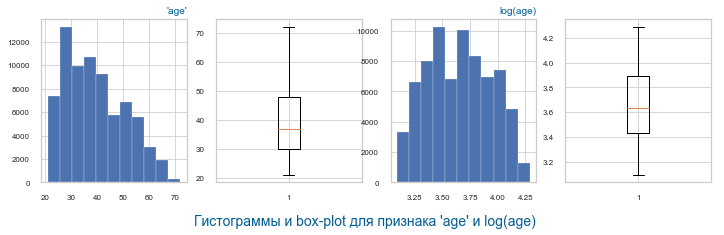

In [238]:
four_plot_with_log2('age', df[df['Train']==1])

In [239]:
describe_without_plots('age', df[df['Train']==1].age)

,age
кол-во строк,73799
тип значений,int64
кол-во значений,73799
кол-во NaN,0
среднее,39.2806
медиана,37
мин,21
макс,72


In [240]:
df['age'] = np.log(df['age'] + 1)

Резюме - Age: Распределение логнормальное , выбросов по квартилям нет. Взяли логарифм от признака

### 2. decline_app_cnt

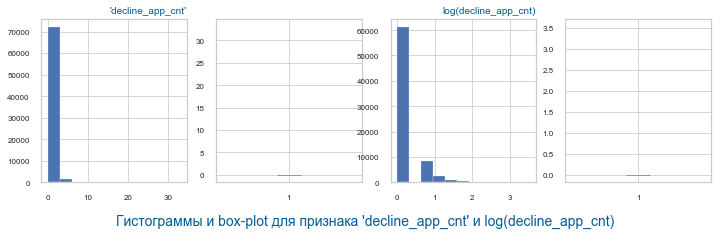

In [241]:
four_plot_with_log2('decline_app_cnt', df[df['Train']==1])

In [242]:
# посмотрим на выбросы - границы (оригинал и логарифм) и их кол-во
borders_of_outliers('decline_app_cnt',df[df['Train']==1], log = True)

,левая,правая
границы выбросов с логарифмом,0.0,0.0
границы выбросов без логарифма,0.0,0.0
кол-во значений за границей,0.0,12585.0


In [243]:
df['decline_app_cnt'] = np.log(df['decline_app_cnt'] + 1)

Резюме - decline_app_cnt: Распределение логнормальное - взяли логарифм, выбросов очень много даже после логарифмирования, поэтому удалять их пока не будем. Построим модель, а потом вернемся к этому вопросу при необходимости.

### 3. bki_request_cnt

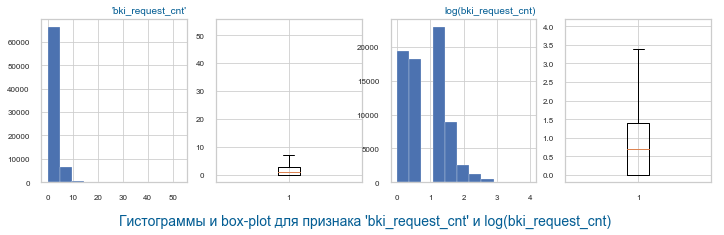

In [244]:
four_plot_with_log2('bki_request_cnt', df[(df['Train']==1)])

In [245]:
# визуально выбросов нет, посмотрим на числовые значения границ
borders_of_outliers('bki_request_cnt',df[df['Train']==1], log = True)

,левая,правая
границы выбросов с логарифмом,-2.079442,3.465736
границы выбросов без логарифма,-0.875000,31.000000
кол-во значений за границей,0.000000,9.000000


In [246]:
df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)

Резюме - bki_request_cnt: Распределение логнормальное - взяли логарифм, выбросов не много, не стали удалять

### 4. income

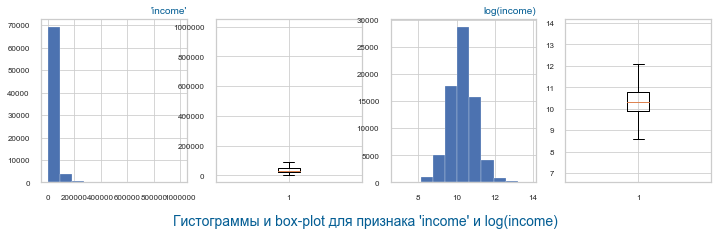

In [247]:
four_plot_with_log2('income', df[df['Train']==1])

In [248]:
borders_of_outliers('income',df[df['Train']==1], log = True)

,левая,правая
границы выбросов с логарифмом,8.590378,12.092136
границы выбросов без логарифма,5378.647840,178461.983007
кол-во значений за границей,595.000000,1172.000000


In [249]:
df['income'] = np.log(df['income'] + 1)

Резюме - income: Распределение логнормальное - взяли логарифм, выбросов очень много и слева и справа даже после логарифмирования, поэтому удалять их пока не будем. Построим модель, а потом вернемся к этому вопросу при необходимости.

### 5.score_bki

,score_bki
кол-во строк,73799
тип значений,float64
кол-во значений,73799
кол-во NaN,0
среднее,-1.90472
медиана,-1.92082
мин,-3.62459
макс,0.199773


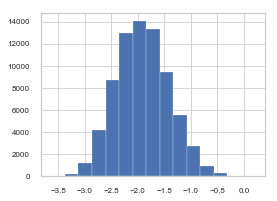

In [250]:
describe_with_hist('score_bki', df[df['Train']==1].score_bki)

In [251]:
borders_of_outliers('score_bki',df[df['Train']==1], log = False)

,левая,правая
границы выбросов,-3.294088,-0.535277
кол-во значений за границей,52.000000,299.000000


Резюме - score_bki: Распределение нормальное. Выбросов не много, не стали удалять

### 6.sna

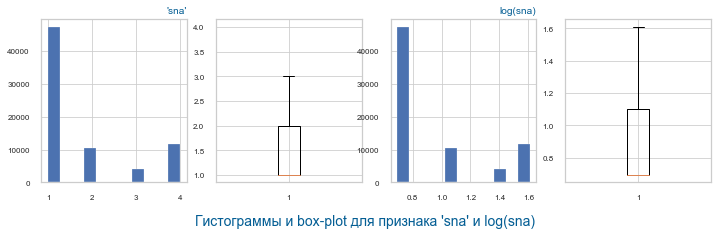

In [252]:
four_plot_with_log2('sna', df[df['Train']==1])

In [253]:
describe_without_plots('sna', df[df['Train']==1].sna)

,sna
кол-во строк,73799
тип значений,int64
кол-во значений,73799
кол-во NaN,0
среднее,1.73333
медиана,1
мин,1
макс,4


Резюме - sna: Распределение смещено вправо - скорее логнормальное. Но не стали пока брать логарифм. Выбросов нет. Всего 4 значения решили использовать как категориальный признак.

### 7.first_time

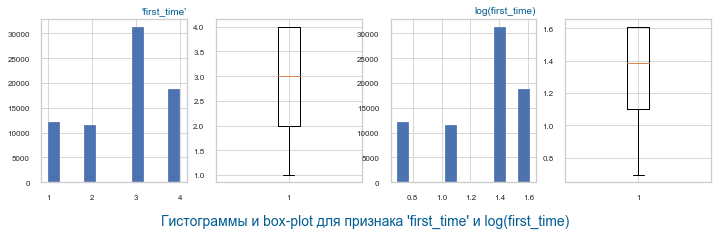

In [254]:
four_plot_with_log2('first_time', df[df['Train']==1])

In [255]:
describe_without_plots('first_time', df[df['Train']==1].sna)

,first_time
кол-во строк,73799
тип значений,int64
кол-во значений,73799
кол-во NaN,0
среднее,1.73333
медиана,1
мин,1
макс,4


Резюме - first_time: Распределение смещено влево - нормальное. Выбросов нет. Всего 4 значения решили использовать как категориальный признак.

### 8.region_rating

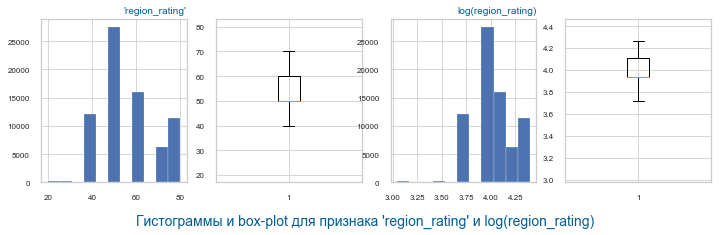

In [256]:
four_plot_with_log2('region_rating', df[df['Train']==1])

In [257]:
describe_without_plots('region_rating', df[df['Train']==1].region_rating)

,region_rating
кол-во строк,73799
тип значений,int64
кол-во значений,73799
кол-во NaN,0
среднее,56.7257
медиана,50
мин,20
макс,80


In [258]:
borders_of_outliers('region_rating',df[df['Train']==1], log = False)

,левая,правая
границы выбросов,35.0,75.0
кол-во значений за границей,506.0,11469.0


Резюме - region_rating: Распределение скорее логнормальное. Выбросов слева в кол-ве 506 по рейтингу региона 30 и 20 в кол-ве 506 в принципе можно было бы удалить, но посмотрим сначала как сработает модель без удаления потом удалим. Справа выбросов очень много но возможно после удаления значений слева распределение сместиться вправо и при логорифмировании выбросы пропадут. Решили использовать как категориальный признак.

### 9. education

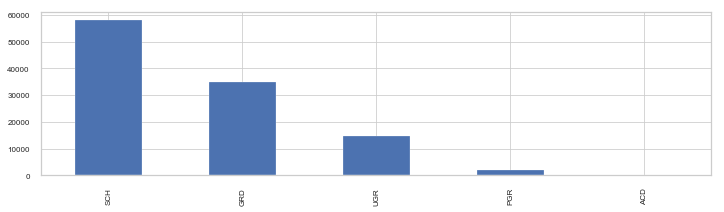

In [259]:
df['education'].value_counts().plot.bar()

In [260]:
# заполним пропуски в education
# переменной education 307 (0.4%) пропущенных значений 
# заполним пропуски самым популярным значением 
df['education'] = df['education'].fillna('SCH')

### 10. app_date - числовой ряд

In [261]:
# Преобразуем формат признака
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

In [262]:
# Выясняем начало и конец периода нашего датасета - это 1 января и 30 апреля 2014 года
start = df.app_date.min()
end = df.app_date.max()
start,end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

In [263]:
# Вводим новый признак - номер дня с 1 января
df['days'] = (df.app_date - start).dt.days.astype('int')

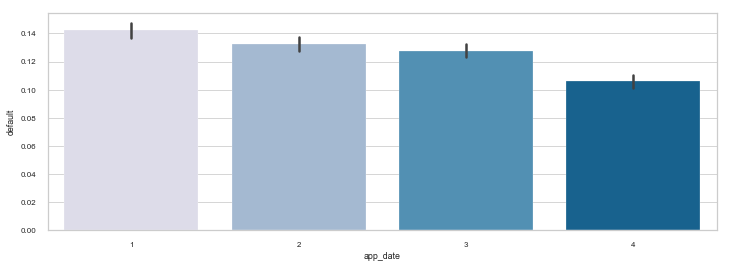

In [264]:
# Среднее число дефолтов по тренировочному датасету отрицательно коррелирует с месяцем подачи заявки
plt.style.use('seaborn-paper')
plt.subplots(figsize=(12, 4))
color_text = plt.get_cmap('PuBu')(0.85)
sns.barplot(data=df[df['Train']==1], x=df.loc[df['Train']==1,'app_date'].dt.month, y='default', palette="PuBu");

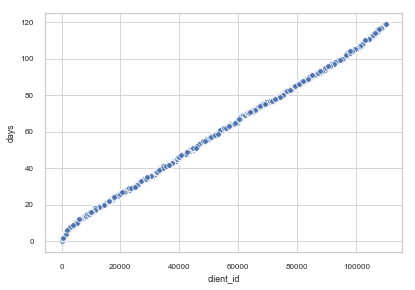

In [265]:
# Выясняем, что в банке велась сквозная нумерация клиентов в зависимости от дня обращения
sns.scatterplot(x='client_id',y='days',data=df)

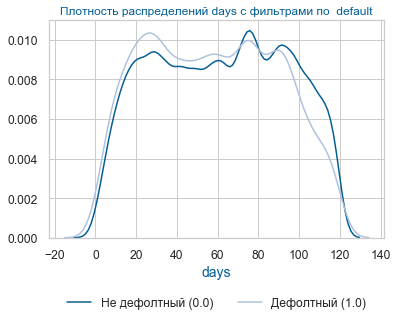

In [266]:
# На более гладком графике видно, что с 90 дня борьба с дефолтами стала успешной
plot_filter_df_kde(['Не дефолтный','Дефолтный'], 'default', 'days', df[df['Train']==1], 1.1)

### 11. Остальные категориальные и бинарные признаки исследовались при выполнении задания на платформе SF

### Оценка корреляций

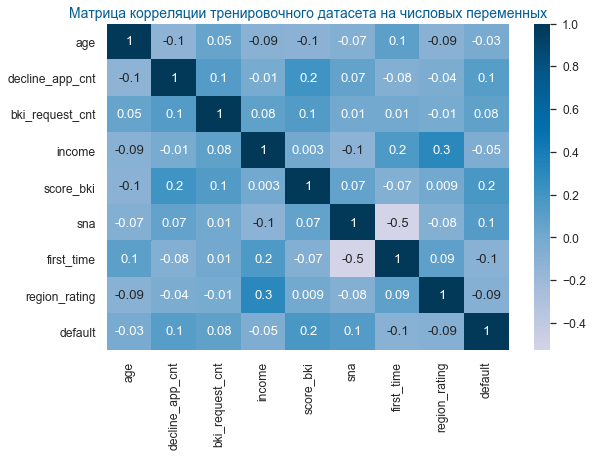

In [267]:
simple_heatmap('Матрица корреляции тренировочного датасета на числовых переменных',df[df['Train']==1], num_cols+['default'], 1.1, 1, 9)

Резюме - сильно скорелированных между собой признаков нет, все берем в работу

### Значимость непрерывных переменных по ANOVA F test

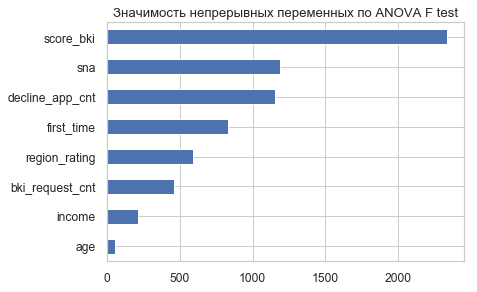

In [268]:
temp_df = df[df['Train']==1]
imp_num = pd.Series(f_classif(temp_df[num_cols], temp_df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных по ANOVA F test')

Резюме - оценка плательщика БКИ (score_bki) самый значимый показатель по ANOVA F test, потом кол-во отказанных заявок (declain_app_cnt) и в конце возраст (age)

### Посмотрим на значимость категориальных и бинарных переменных

['work_address', 'home_address', 'sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'education_l']


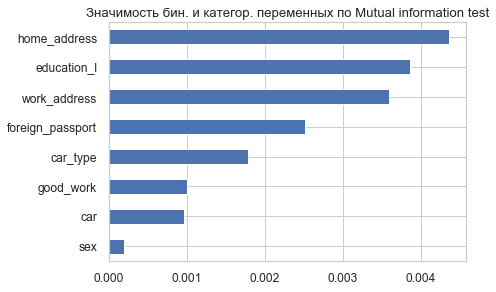

In [269]:
label_encoder = LabelEncoder()
df['education_l'] = label_encoder.fit_transform(df['education'])

# паралельно подготовим бинарные переменные и переведем их в числовой формат
# для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# тут могут быть потенциальные даталики, но мы пока не придумали как это обработать,
# потому что далее по этим меткам формируются новые фичи по get_dummies

all_cat_and_bin_cols = cat_cols+bin_cols
all_cat_and_bin_cols.remove('education')
all_cat_and_bin_cols.append('education_l')
print(all_cat_and_bin_cols)

temp_df = df[df['Train']==1]
imp_cat = pd.Series(mutual_info_classif(temp_df[all_cat_and_bin_cols], temp_df['default'], discrete_features =True), index = all_cat_and_bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', title = 'Значимость бин. и категор. переменных по Mutual information test')

Резюме - Самым значимым признаком по Mutual information тесту является связь заемщика с клиентами банка (sna) и давность наличия информации о заемщике (first_time), потом идет рейтинг региона (region_rating) и в конце пол (sex).

## 5. Подготовка данных к машинному обучению

### Категориальные признаки

In [270]:
# реализуем метод OneHotLabels через get_dummies
df=pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

### Стандартизация

In [271]:
# стандартизацию проводим отдельно для трейна и теста, чтобы не допустить даталиков
StandardScaler_df_and_filna_0(df[df['Train']==1], num_cols)
StandardScaler_df_and_filna_0(df[df['Train']==0], num_cols)

### Построчная верификация первых двух строк

In [272]:
display(df.head(2))

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,sna,first_time,foreign_passport,default,Train,days,education_l,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,work_address_1,work_address_2,work_address_3,home_address_1,home_address_2,home_address_3
0,25905,2014-02-01,1,4.143135,1,1,0.0,0,-2.008753,0.693147,50,9.798183,4,1,0,0.0,1,31,3,0,0,0,1,0,0,1,0,1,0,0
1,63161,2014-03-12,0,4.094345,0,0,0.0,0,-1.532276,1.386294,50,9.852247,4,1,0,0.0,1,70,3,0,0,0,1,0,0,0,1,0,1,0


### Удаление нечисловых критериев

In [273]:
df.drop(['app_date', 'education_l'], axis=1, inplace=True)

## 6. Построение модели

### Разбиваем датасет на тренировочный и тестовый

In [274]:
train_data = df.query('Train == 1').drop(['Train', 'client_id'], axis=1)
test_data = df.query('Train == 0').drop(['Train', 'client_id'], axis=1)

y = train_data.default.values            # наш таргет
X = train_data.drop(['default'], axis=1)

In [275]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [276]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((36349, 26), (73799, 26), (73799, 25), (59039, 25), (14760, 25))

### Обучаем модель, генерируем результат и сравниваем с тестом

In [277]:
# первая модель на автомате
model = LogisticRegression(random_state=RANDOM_SEED)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

### Оценка качества модели
### Качественные метрики

In [278]:
# в первый раз инициируем глобальную переменную с предыдущим скором
last_pred = np.zeros((3,len(y_test)))

In [279]:
test_last_pred(y_test, y_pred, y_pred_prob) if (last_pred[0].max() == 0) else 0
all_metrics(y_test, y_pred, y_pred_prob)

,Значение,Дельта с предыдущим,Описание
accuracy,0.874593,0.0,(TP+TN)/(P+N)
balanced accuracy,0.508943,0.0,сбалансированная accuracy
precision,0.388889,0.0,точность = TP/(TP+FP)
recall,0.022989,0.0,полнота = TP/P
f1_score,0.043411,0.0,среднее гармоническое точности и полноты
roc_auc,0.743343,0.0,Area Under Curve - Receiver Operating Characte...


### Матрица ошибок

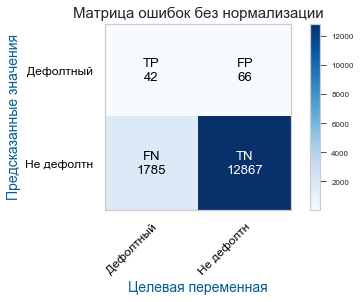

In [280]:
confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1.2, normalize=False)

### ROC кривая

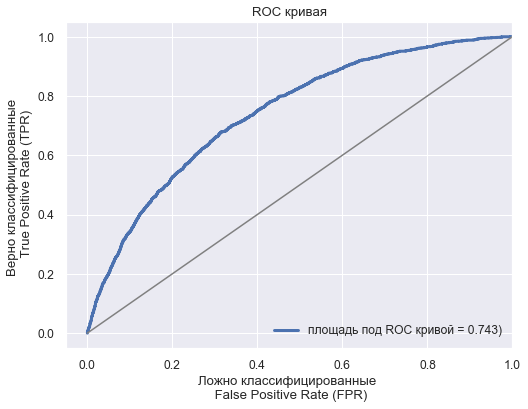

In [281]:
ROC_curve_with_area(y_test, y_pred_prob, 1.1)

Резюме - прекрасный пример несостоятельности метрики ROC-AUC на не сбалансированных данных. Мы абсолютно не угадали дефолтных клиентов, тем самым обеспечили себе огромную ошибку второго рода и как следствие колосальный убыток, но ROC-AUC у нас высокий. Благо f1 как-то сигнализирует о том что что-то не впорядке. Надо посмотреть на метрику которая может оценивать эффективность алгоритма на несбалансированных данных - PRC-AUC.

### Precision-Recall кривая

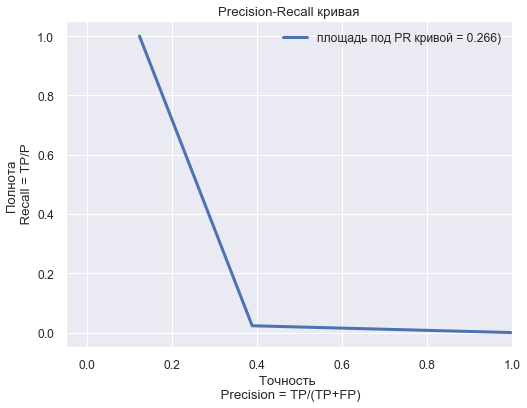

In [282]:
PR_curve_with_area(y_test, y_pred, 1.1)

### Кросс-валидация

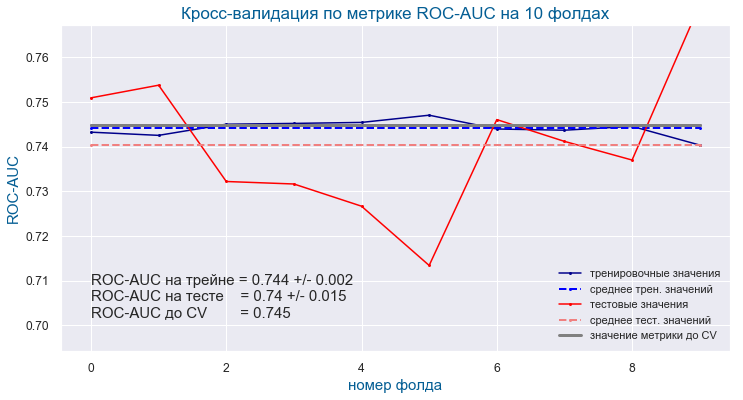

In [283]:
temp_vec = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)
vis_cross_val_score('ROC-AUC', temp_vec, 0.744846, 1.1)

Резюме - Видно что при разбиении на 10 фолдов ROC-AUC меняется не сильно, есть один провал до 0.716. Среднее по фолдам примерно равно предсказанному значению до кроссвалидации 0.744, дисперсия 0.015, поэтому можно попробовать докрутить параметры, провести отбор признаков и делать сабмишен. Также можно попробовать прокрутить модель на регуляризации первого порядка l1 и попробовать избавиться от каких-нибудь признаков, которые не нравятся модели.

Проверка нулевых коэффициэнтов при регуляризации первого порядка

In [284]:
# регуляризация первого порядка l1 позволяет оценить по нулевым или слишком низким коэффициентам признаки,
# которые не нравятся модели (в них могут быть выбросы или неподходящий формат)
# можно это поможет избавиться от большой дисперсии при кросс-валидации
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'l1', 
                           solver = 'liblinear', 
                           verbose= 0, 
                           warm_start= False)

model.fit(X_train, y_train)

display(model_coef(X_train.columns, model.coef_[0]))

,имя признака,коэффициент модели
0,score_bki,0.972561
1,education_SCH,0.670811
2,education_UGR,0.518006
3,home_address_2,0.517091
4,decline_app_cnt,0.414709
5,work_address_3,0.401951
6,work_address_2,0.305181
7,bki_request_cnt,0.282765
8,sex,0.282382
9,car_type,-0.282299


Резюме - влияние score_bki самое большое, следом идут разные значения рейтинга региона, школьное образование, кол-во отказов.
Кандидаты на удаление:

work_address_1
home_address_1
sna_3
region_rating_60
first_time_3
education_PGR

In [288]:
# формируем список отсева признаков
drop_list_cols = ['work_address_1', 'home_address_1', 'education_PGR']
#drop_list_cols = ['work_address_1', 'home_address_1', 'sna_3', 'region_rating_60', 'first_time_3', 'education_PGR']

In [289]:
#заново формируем выборки для обучения без этих признаков
train_data = df.query('Train == 1').drop(['Train', 'client_id']+drop_list_cols, axis=1)
test_data = df.query('Train == 0').drop(['Train', 'client_id']+drop_list_cols, axis=1)

y = train_data.default.values            # наш таргет
X = train_data.drop(['default'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

### Проверка качества модели после удаления признаков

In [290]:
# вторая модель на параметрах после первой оптимизации
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'l2', 
                           solver = 'sag', 
                           verbose= 0, 
                           warm_start= False)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

test_last_pred(y_test, y_pred, y_pred_prob) if (last_pred[0].max() == 0) else 0
all_metrics(y_test, y_pred, y_pred_prob)

,Значение,Дельта с предыдущим,Описание
accuracy,0.672900,0.201694,(TP+TN)/(P+N)
balanced accuracy,0.677744,-0.168801,сбалансированная accuracy
precision,0.227231,0.161657,точность = TP/(TP+FP)
recall,0.684182,-0.661193,полнота = TP/P
f1_score,0.341157,-0.297746,среднее гармоническое точности и полноты
roc_auc,0.742684,0.000660,Area Under Curve - Receiver Operating Characte...


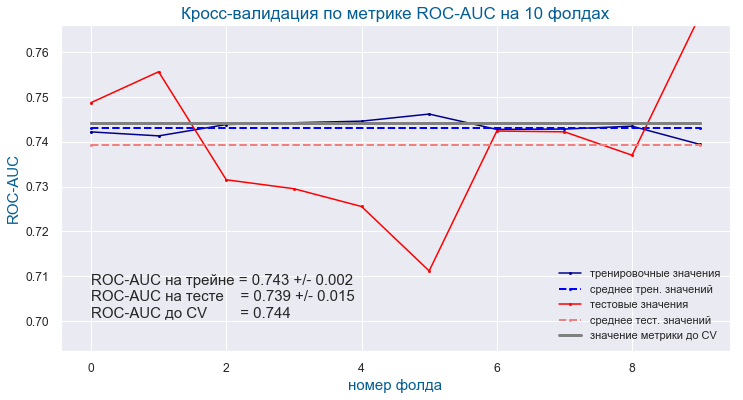

In [291]:
temp_vec = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)
vis_cross_val_score('ROC-AUC', temp_vec, 0.744262, 1.1)

### Поиск оптимальных параметров модели

In [292]:
# блок поиска параметров закомментирован потому что он выполняется очень долго, ниже модель использует оптимальные параметры 

# model = LogisticRegression(multi_class = 'ovr', class_weight='balanced', solver='liblinear', random_state=RANDOM_SEED)

# param_grid = [
#     {'penalty': ['l1'], 'C':[0.1, 1, 10], 'max_iter':[1000],'tol':[1e-5]},
#     {'penalty': ['l2'], 'C':[0.1, 1, 10], 'max_iter':[1000],'tol':[1e-5]},
#     {'penalty': ['none'], 'max_iter':[1000],'tol':[1e-5]},
# ]
# gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
# gridsearch.fit(X_train, y_train)
# model = gridsearch.best_estimator_
# ##печатаем параметры
# best_parameters = model.get_params()
# for param_name in sorted(best_parameters.keys()):
#         print('\t%s: %r' % (param_name, best_parameters[param_name]))
#     ##печатаем метрики
# preds = model.predict(X_test)
# print('Accuracy: %.4f' % accuracy_score(y_test, preds))
# print('Precision: %.4f' % precision_score(y_test, preds))
# print('Recall: %.4f' % recall_score(y_test, preds))
# print('F1: %.4f' % f1_score(y_test, preds))

In [293]:
# третья модель
model = LogisticRegression(C=7, 
                           penalty='l2', 
                           multi_class = 'ovr', 
                           class_weight='balanced', 
                           solver='liblinear', 
                           random_state=RANDOM_SEED,
                           max_iter = 1000)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

In [294]:
test_last_pred(y_test, y_pred, y_pred_prob) if (last_pred[0].max() == 0) else 0
all_metrics(y_test, y_pred, y_pred_prob)

,Значение,Дельта с предыдущим,Описание
accuracy,0.671883,0.001016,(TP+TN)/(P+N)
balanced accuracy,0.676929,0.000815,сбалансированная accuracy
precision,0.226514,0.000717,точность = TP/(TP+FP)
recall,0.683634,0.000547,полнота = TP/P
f1_score,0.340281,0.000877,среднее гармоническое точности и полноты
roc_auc,0.743545,-0.000861,Area Under Curve - Receiver Operating Characte...


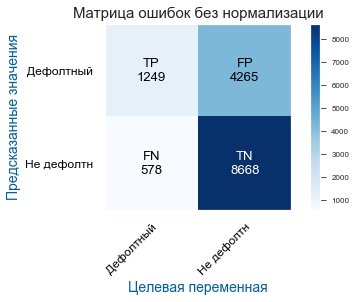

In [295]:
confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1.2, normalize=False)

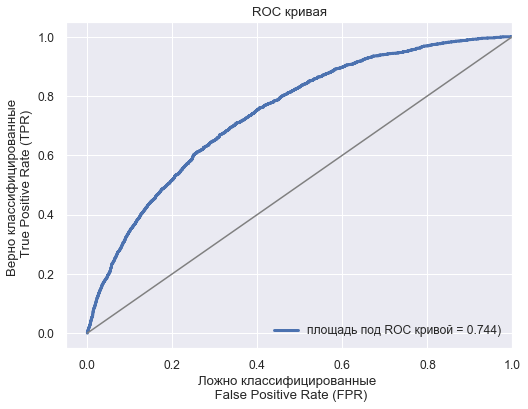

In [296]:
ROC_curve_with_area(y_test, y_pred_prob, 1.1)

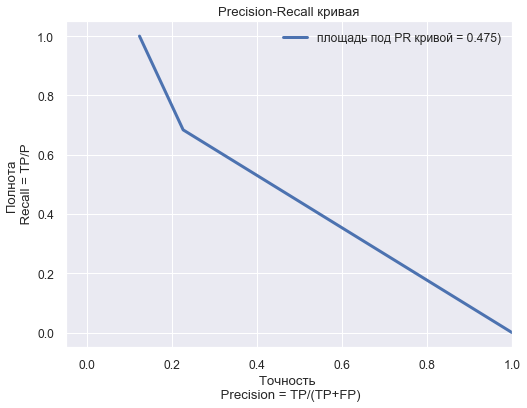

In [297]:
PR_curve_with_area(y_test, y_pred, 1.1)

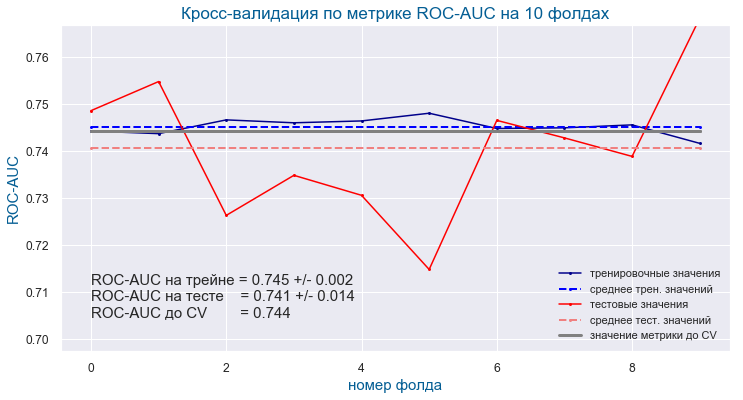

In [298]:
temp_vec = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)
vis_cross_val_score('ROC-AUC', temp_vec, 0.744262, 1.1)

### Отбор признаков

In [299]:
# отбор признаков не удалось довести до конца даже на локальной машине, поэтому тут просто приводится код

# model = LogisticRegression(C=7, penalty='l2', multi_class = 'ovr', class_weight='balanced', solver='liblinear', random_state=RANDOM_SEED)

# efs1 = EFS(model, 
#            min_features=1,
#            max_features=10,
#            scoring='roc_auc',
#            print_progress=True,
#            cv=5)

# efs1 = efs1.fit(X_train, y_train)

# print('Best roc_auc score: %.2f' % efs1.best_score_)
# print('Best subset (indices):', efs1.best_idx_)
# print('Best subset (corresponding names):', efs1.best_feature_names_)

## Submission

In [300]:
train_data = df.query('Train == 1').drop(['Train', 'client_id']+drop_list_cols, axis=1)
test_data = df.query('Train == 0').drop(['Train', 'client_id']+drop_list_cols, axis=1)

In [301]:
X_train=train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [302]:
# проверяем
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 23), (73799, 23), (73799, 22), (73799,), (36349, 22))

In [303]:
model = LogisticRegression(C=7, 
                           penalty='l2', 
                           multi_class = 'ovr', 
                           class_weight='balanced', 
                           solver='liblinear', 
                           random_state=RANDOM_SEED,
                           max_iter=1000)

model.fit(X_train, y_train)

LogisticRegression(C=7, class_weight='balanced', max_iter=1000,
                   multi_class='ovr', random_state=42, solver='liblinear')

In [305]:
y_pred_prob = model.predict_proba(X_test)[:,1]


submit = pd.DataFrame(df_test.client_id)
submit['default']=y_pred_prob
submit.to_csv(PATH_to_file+'submission.csv', index=False)

Резюме:
не хватило времени почистить от выбросов признак income и запустить EFS